<a href="https://colab.research.google.com/github/nisha1365/-Playground-Series---Season-3-Episode-14/blob/main/LGBM_PS_S3_E14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [3]:
train_df.columns

Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [4]:
train_df.head(1)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.5,0.25,0.75,0.5,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146


In [5]:
test_df.head(1)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569


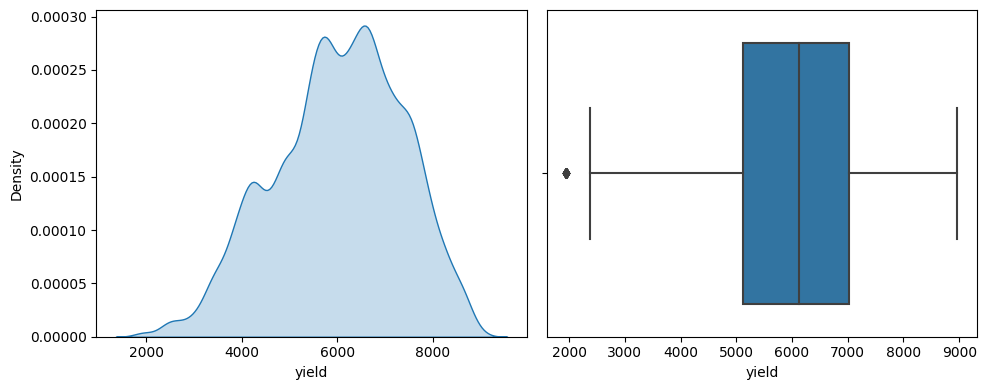

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.kdeplot(data=train_df, x='yield', fill=True)

plt.subplot(1,2,2)
sns.boxplot(data=train_df, x='yield')

plt.tight_layout()

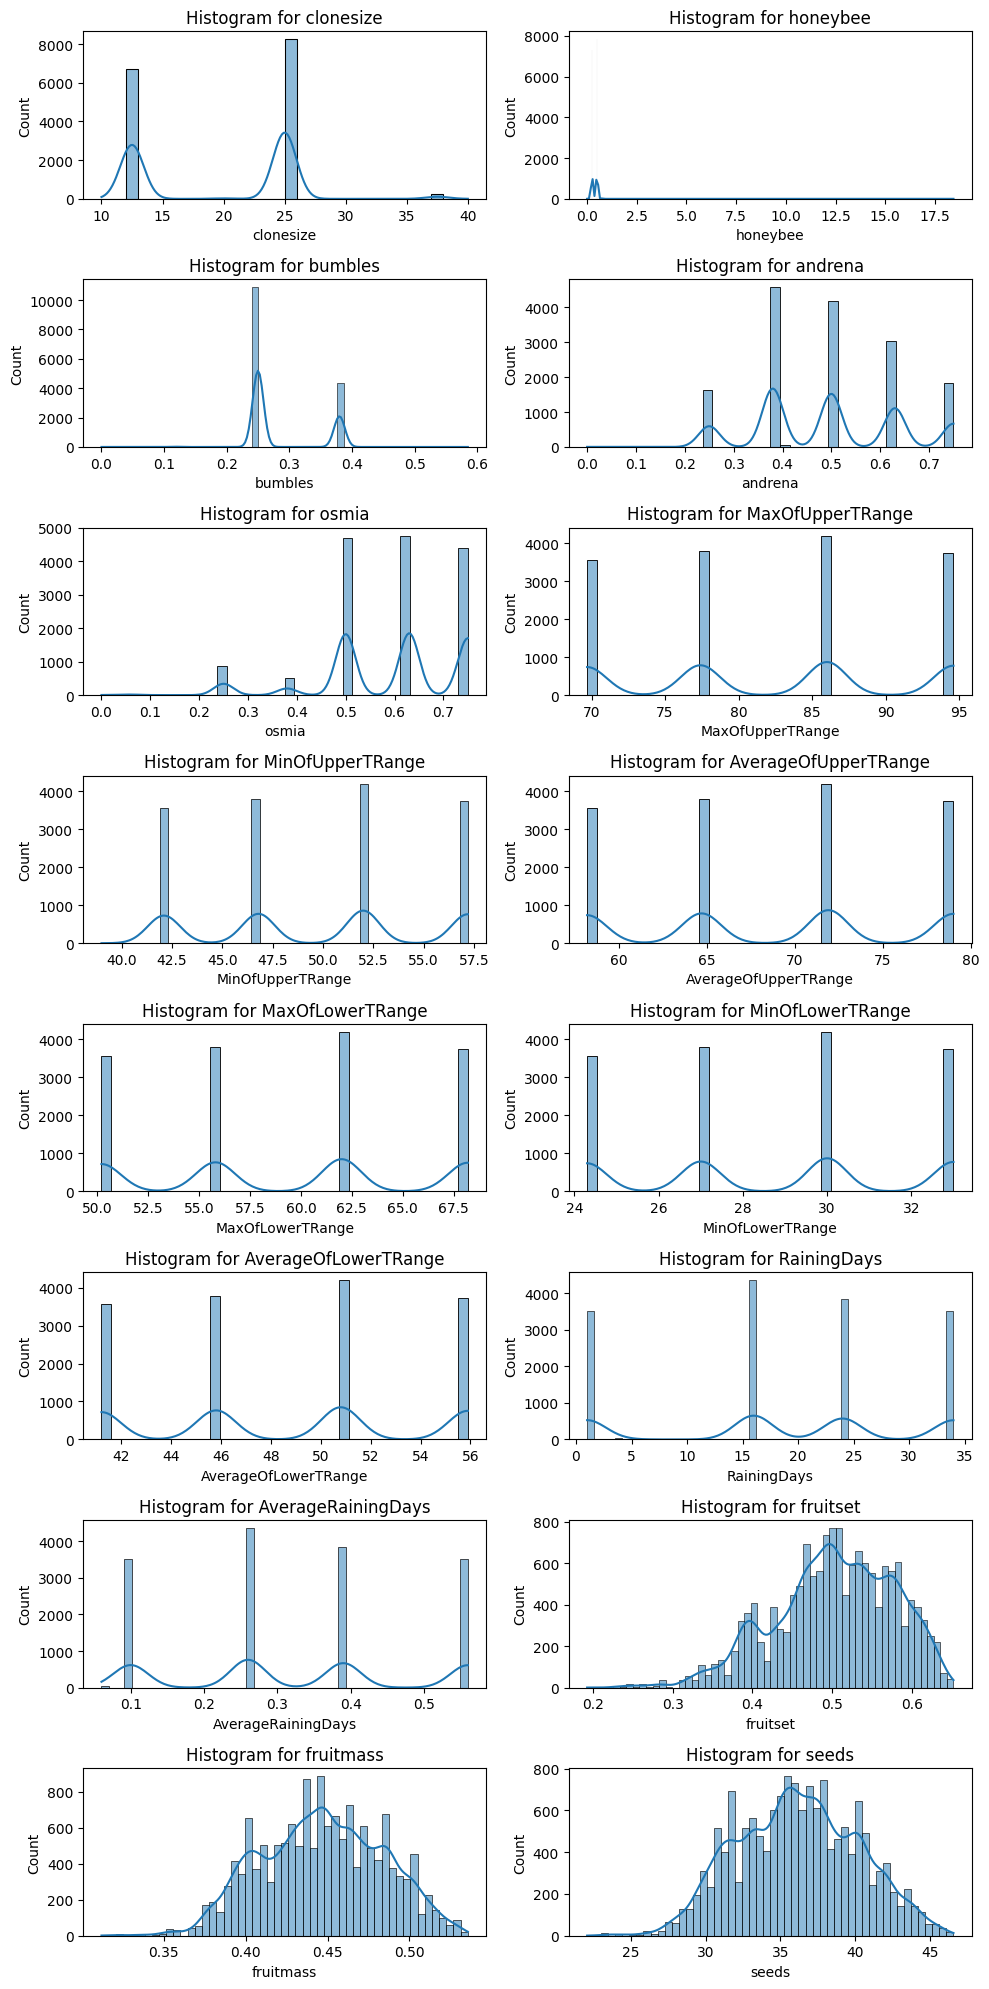

In [8]:
plt.figure(figsize=(10,20))
plotnumber = 1

for col in train_df.columns[1:-1]:
    ax1 = plt.subplot(8,2,plotnumber)
    sns.histplot(data=train_df, x=col, kde=True)
    plt.title(f"Histogram for {col}")
    plotnumber += 1

plt.tight_layout()

<Axes: >

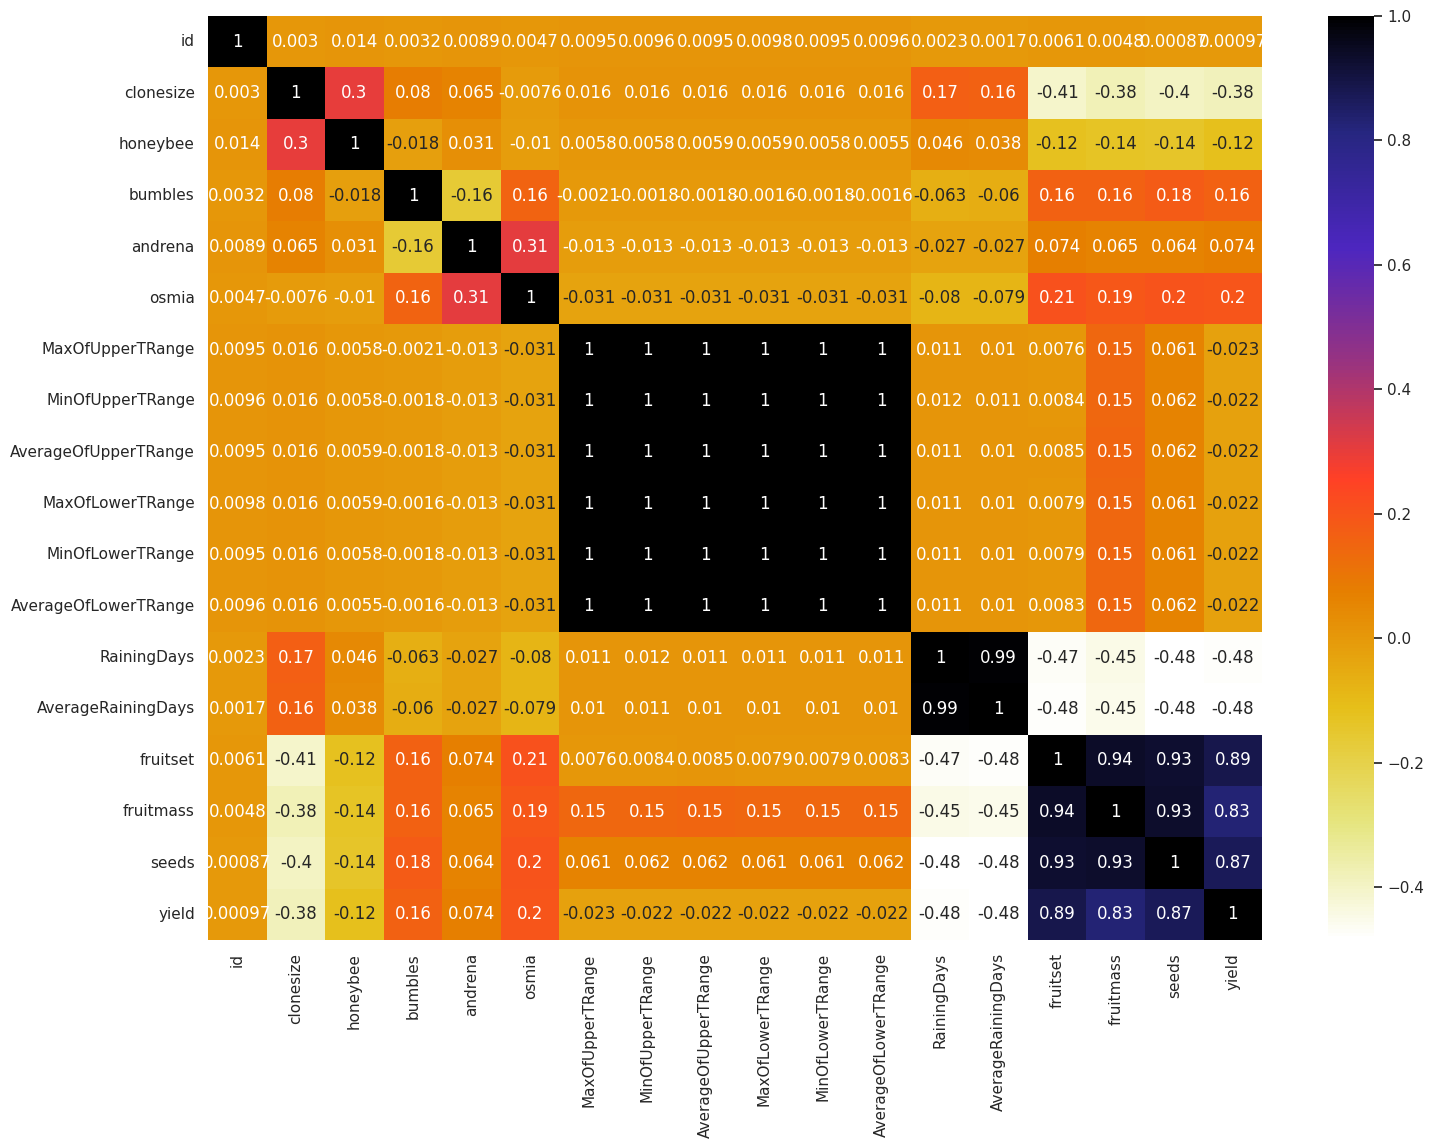

In [9]:
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(train_df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

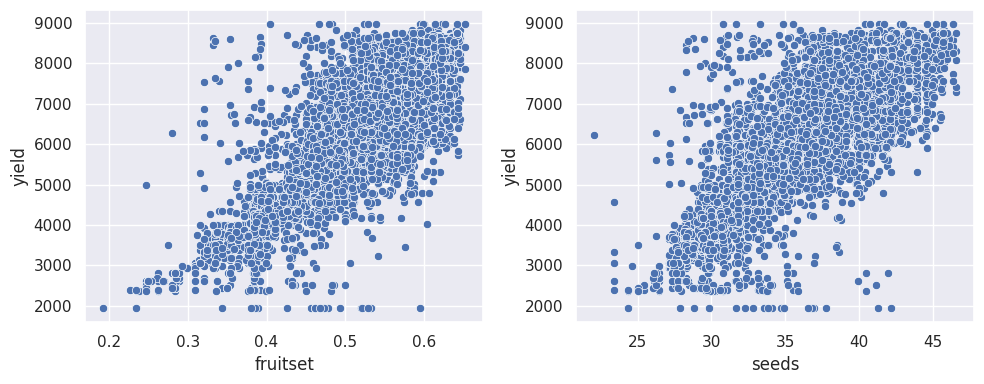

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(data=train_df, x="fruitset", y="yield")

plt.subplot(1,2,2)
sns.scatterplot(data=train_df,x="seeds", y="yield")

plt.tight_layout()

In [11]:
X = train_df.drop(columns=["id", "yield"])
y = train_df['yield']

In [12]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping, log_evaluation

In [13]:
n_splits = 5
cv = list(KFold(n_splits=n_splits, shuffle=True, random_state=0).split(X, y))
model_list =[]
params = {
    "boosting_type": "gbdt",
    "objective": "regression_l1",
    "metric": "mean_absolute_error",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "n_estimators": 10000,
    "random_state": 0,
    "importance_type": "gain"
}

for fold, (train_idx, val_idx) in enumerate(cv, start=1):
    X_train = X.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params, verbose = -1)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            callbacks=[early_stopping(stopping_rounds=1000), 
                       log_evaluation(period=0)]
            )
    # make predictions on the validation data
    y_pred = model.predict(X_val)

    # evaluate the model's performance using mean squared error
    mae = mean_absolute_error(y_val, y_pred)

    # store the evaluation results for this fold
    print('fold :'+str(fold)+ ' / MAE: ', mae)
    model_list.append(model)

Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1741]	training's l1: 295.541	valid_1's l1: 343.628
fold :1 / MAE:  343.62800342020745
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[597]	training's l1: 312.037	valid_1's l1: 350.682
fold :2 / MAE:  350.68160579772155
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[588]	training's l1: 314.527	valid_1's l1: 345.568
fold :3 / MAE:  345.56771320964384
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2382]	training's l1: 294.079	valid_1's l1: 347.601
fold :4 / MAE:  347.60120272587943
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[822]	training's l1: 310.771	valid_1's l1: 327.625
fold :5 / MAE:  327.6250566574577


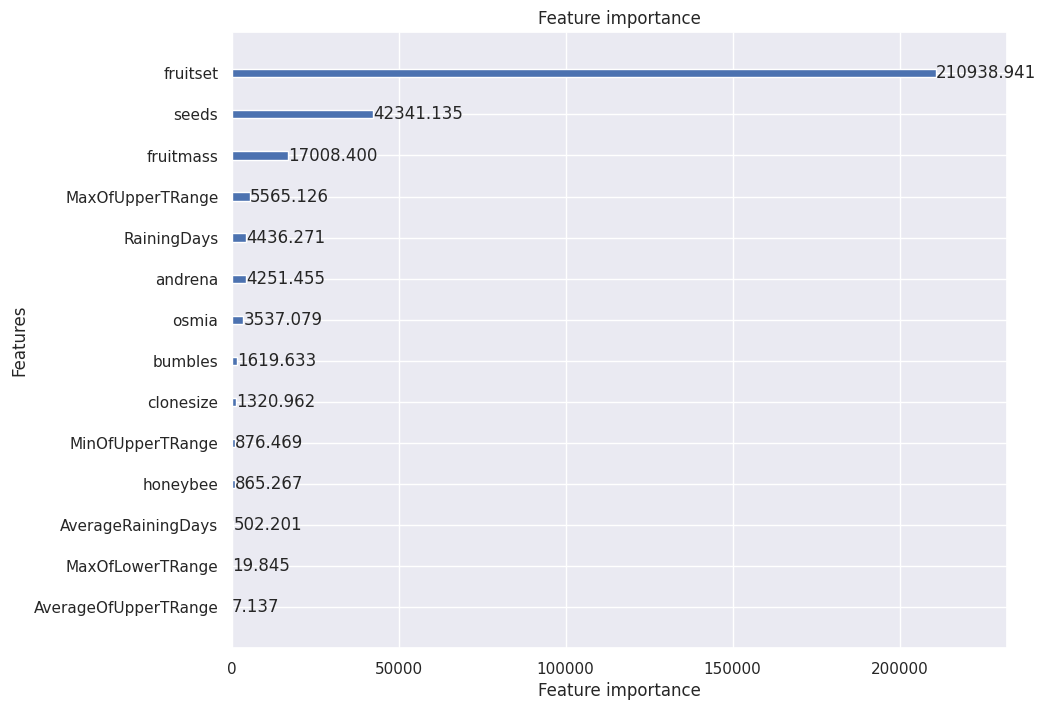

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(model_list[0], ax=ax)
plt.show()

In [15]:
y = []
for model in model_list:
    y.append(model.predict(test_df[test_df.columns[1:]]))

In [16]:
ensemble_result  = np.mean(y, axis=0)

In [17]:
ensemble_result

array([4280.49232255, 5911.63163925, 7192.14998155, ..., 6496.53626854,
       4397.05587608, 7262.98179837])

In [19]:
sample_df = pd.read_csv('/content/sample_submission.csv')

In [20]:
sample_df.head(2)

,id,yield
0,15289,6025.194
1,15290,6025.194


In [21]:
sample_df['yield'] = ensemble_result
sample_df.to_csv('submission.csv', index=False)
sample_df.head()

,id,yield
0,15289,4280.492323
1,15290,5911.631639
2,15291,7192.149982
3,15292,4657.496685
4,15293,3812.642159
